# Loan Classifier

In this project, you will complete a notebook where you will build a classifier to predict whether a loan case will be paid off or not.

You load a historical dataset from previous loan applications, clean the data, and apply different classification algorithm on the data. You are expected to use the following algorithms to build your models:

- k-Nearest Neighbour
- Decision Tree
- Support Vector Machine
- Logistic Regression

The results is reported as the accuracy of each classifier, using the following metrics when these are applicable:

- Jaccard index
- F1-score
- LogLoass

## Import Necessary Libraries

In [1]:
import itertools
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

## About Dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant     

### Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-03-11 12:52:44--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  84.0KB/s    in 0.3s    

2020-03-11 12:52:45 (84.0 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [3]:
df = pd.read_csv('loan_train.csv')
print(df.shape)
df.head()


(346, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


# Data visualization and pre-processing

## Convert Categorical features to numerical values

### Look at gender:


In [4]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

__86 % of female pay there loans while only 73 % of males pay there loan__

Lets convert male to 0 and female to 1:

In [5]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,0
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,1
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,0
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,1
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,0


## Lets look at the day of the week people get the loan 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0


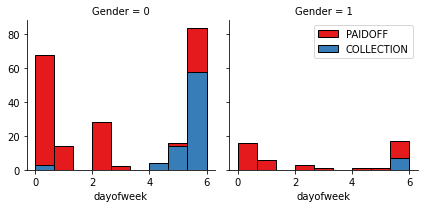

In [7]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [8]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


##  Loan Status

In [9]:
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0], inplace=True)
df.tail()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
341,394,394,0,800,15,2016-09-11,2016-09-25,32,High School or Below,0,6,1
342,395,395,0,1000,30,2016-09-11,2016-10-10,25,High School or Below,0,6,1
343,397,397,0,800,15,2016-09-12,2016-09-26,39,college,0,0,0
344,398,398,0,1000,30,2016-09-12,2016-11-10,28,college,0,0,0
345,399,399,0,1000,30,2016-09-12,2016-10-11,26,college,0,0,0


### Look at Education:

In [10]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              1              0.750000
                      0              0.250000
High School or Below  1              0.741722
                      0              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               1              0.765101
                      0              0.234899
Name: loan_status, dtype: float64

as __Master or Above is 50/50__ so it doesn't make any impact on our model but all the other impact our model, so we ommit Master or Above from our training dataset.

we also ommit __Unnamed: 0	Unnamed: 0.1__ as the doesn't have any meaning.

### So Our Featured dataset will be 

In [11]:
df = df[['Principal','terms','age','Gender','education','weekend', 'loan_status']]

In [12]:
df.head()

,Principal,terms,age,Gender,education,weekend,loan_status
0,1000,30,45,0,High School or Below,0,1
1,1000,30,33,1,Bechalor,0,1
2,1000,15,27,0,college,0,1
3,1000,30,28,1,college,1,1
4,1000,30,29,0,college,1,1


### Now we conver categorical varables to binary variables and append them to the feature Data Frame 

In [13]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


# Feature selection


In [14]:
# Lets defind feature sets, X:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [15]:
# What are our lables?
y = df['loan_status'].values
y[-5:]

array([0, 0, 0, 0, 0])

__Now Our Dataset are ready so we now go for training our model__

# Train Test Split

In [16]:
from sklearn.model_selection import train_test_split

# X = preprocessing.StandardScaler().fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.15, random_state=40)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
X[:10]


Train set: (294, 8) (294,)
Test set: (52, 8) (52,)


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1
5,1000,30,36,0,1,0,0,1
6,1000,30,28,0,1,0,0,1
7,800,15,26,0,1,0,0,1
8,300,7,29,0,1,0,0,1
9,1000,15,39,0,1,0,1,0


In [17]:
X_train[:10]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
257,1000,30,29,0,0,0,1,0
37,1000,15,24,1,1,1,0,0
21,1000,30,29,0,1,0,1,0
102,1000,15,23,0,1,0,0,1
232,1000,30,29,0,0,0,1,0
209,1000,7,31,0,0,0,0,1
260,1000,15,29,0,1,0,0,1
26,800,15,33,0,1,0,1,0
160,800,15,42,0,0,0,0,1
0,1000,30,45,0,0,0,1,0


# Classifications

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
We use the following algorithm:

- __K Nearest Neighbor(KNN)__
- __Decision Tree__
- __Support Vector Machine__
- __Logistic Regression__


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# KNN

### Find the best K

In [19]:
# Classifier implementing the k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score, log_loss, classification_report, confusion_matrix,jaccard_score


In [20]:
Ks =100
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    #print("for {} accuracy {}".format(n,mean_acc[n-1]))


In [21]:
print( "The best accuracy on training data:", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy on training data: 0.8653846153846154 with k= 9


In [22]:
# Jaccard Similarity
neigh = KNeighborsClassifier(n_neighbors = 19).fit(X_train,y_train)

yhat_knn=neigh.predict(X_test)
jac = jaccard_similarity_score(y_test, yhat_knn)
jac

/home/sharif/projects/Own_Projects/Loan_Classifier/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.8461538461538461

In [23]:
print(classification_report(y_test, yhat_knn))

              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.86      0.98      0.91        43

    accuracy                           0.85        52
   macro avg       0.76      0.60      0.62        52
weighted avg       0.82      0.85      0.81        52



## Confusion Matrix

Confusion matrix, without normalization
[[ 2  7]
 [ 1 42]]


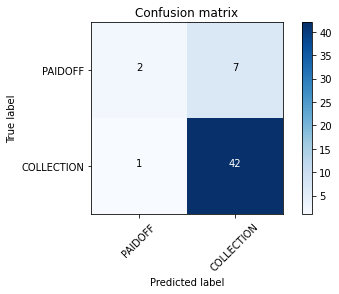

In [24]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_knn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [25]:
print(y_test)
print(yhat_knn)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Modeling
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
print(LR)

#Prediction
yhat_lr = LR.predict(X_test)
print(yhat_lr)
print(y_test)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0]


In [91]:
# Jaccard Similarity
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat_lr)

0.8269230769230769

In [90]:
# # F1 Score
# print(classification_report(y_test, yhat_lr))

from sklearn.metrics import f1_score
f1_score(y_test, yhat_lr, average='weighted')

0.748582995951417

In [88]:
# Log Loss
yhat_prob = LR.predict_proba(X_test)
yhat_prob

log_loss(y_test, yhat_prob)

0.450656217017712

## Confusion Matrix

Confusion matrix, without normalization
[[ 0  9]
 [ 0 43]]


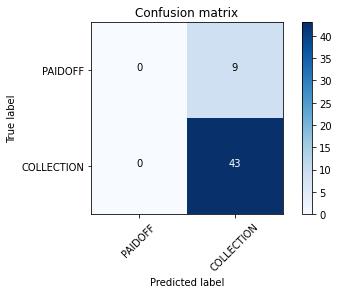

In [28]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_lr)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

# Decision Tree

In [77]:
# Modeling
from sklearn.tree import DecisionTreeClassifier
d_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)


# Training
d_tree = d_tree.fit(X_train, y_train)
print(d_tree)

# Prediction
pred_tree = d_tree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, pred_tree))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
DecisionTrees's Accuracy:  0.8269230769230769


In [70]:
# Compare Result 
print(y_test)
print(pred_tree)

DecisionTrees's Accuracy:  0.8269230769230769
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [80]:
# Jaccard Similarity
from sklearn.metrics import jaccard_similarity_score

jaccard_similarity_score(y_test, pred_tree)

0.8269230769230769

In [82]:
# F1 Socre
from sklearn.metrics import f1_score
f1_score(y_test, pred_tree, average='weighted')

0.748582995951417

Confusion matrix, without normalization
[[ 0  9]
 [ 0 43]]


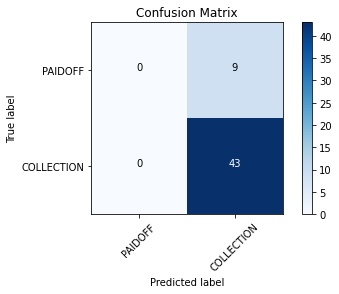

In [83]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_tree)
np.set_printoptions(precision=2)


# print(classification_report(y_test, yhat))


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion Matrix')

# SVM

In [56]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
yhat = clf.predict(X_test)
yhat 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [58]:
# F1 Socre
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.748582995951417

In [62]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.8269230769230769